In [ ]:
from zipfile import ZipFile
file_name = "brain_tumor_dataset.zip"
with ZipFile(file_name,'r')as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!rm -rf sample_data

In [ ]:
!pip install -q keras

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob
import cv2
import imutils 
import seaborn as sns
from sklearn.utils import shuffle
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
import keras

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout
from sklearn.metrics import accuracy_score

In [ ]:
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

In [ ]:
data_path = '/content/brain_tumor_dataset'
classes = ['no', 'yes']
img_size = 224

X = []
Y = []
for c in classes:
    path = os.path.join(data_path, c)
    class_num = classes.index(c)
    for img in os.listdir(path):
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
        img_arr = cv2.resize(img_arr, (img_size, img_size))
        X.append(img_arr)
        Y.append(class_num)

X = np.array(X)
Y = np.array(Y)
Y = to_categorical(Y, num_classes=len(classes))

In [ ]:
X,Y = shuffle(X,Y,random_state=101)
X.shape

(253, 224, 224, 3)

In [ ]:
root =  '/content/brain_tumor_dataset'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'yes': 155, 'no': 98}

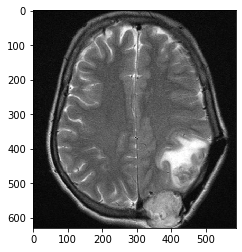

In [ ]:
from tensorflow.keras.preprocessing import image
img = image.load_img('/content/brain_tumor_dataset/yes/Y102.jpg')
plt.imshow(img,interpolation='nearest')
plt.show()

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest',
                                  rescale= 1/255
                                 )

    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [ ]:
name = 'aug_data'
if not os.path.exists("./"+name):
  os.mkdir("./"+name)
  for dir in os.listdir(root):
    os.makedirs("./"+name+"/"+dir)
else:
  print(f"{name} Already exists")

In [ ]:
augment_data(file_dir='./brain_tumor_dataset/yes',n_generated_samples=8, save_to_dir='./aug_data/yes')
augment_data(file_dir='./brain_tumor_dataset/no', n_generated_samples=12, save_to_dir='./aug_data/no')

In [ ]:
root =  '/content/aug_data'
dict_img = {}
for dir in os.listdir(root):
  dict_img[dir] = len(os.listdir(os.path.join(root, dir)))
dict_img 

{'yes': 1395, 'no': 1274}

In [ ]:
def create_folders(name, perc):
  if not os.path.exists("./"+name):
    os.mkdir("./"+name)
    for dir in os.listdir(root):
      os.makedirs("./"+name+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root, dir)), size=(math.floor(perc*dict_img[dir])), replace=False):
        Src = os.path.join(root, dir, img)
        Dest = os.path.join("./"+name, dir)
        shutil.copy(Src, Dest)
        os.remove(Src)
  else:
    print(f"{name} Already exists")

In [ ]:
create_folders('train', 0.7)

In [ ]:
create_folders('test', 0.15)

In [ ]:
create_folders('val', 0.15)

In [ ]:
def count_img(folder):
  dict_img = {}
  for dir in os.listdir(folder):
    dict_img[dir] = len(os.listdir(os.path.join(folder, dir)))
  return dict_img

In [ ]:
count_img('train')

{'yes': 976, 'no': 891}

In [ ]:
count_img('test')

{'yes': 209, 'no': 191}

In [ ]:
count_img('val')

{'yes': 209, 'no': 191}

In [ ]:
def crop_brain_contour(image, plot=False):
    
    #Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    #Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    #Extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #Crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

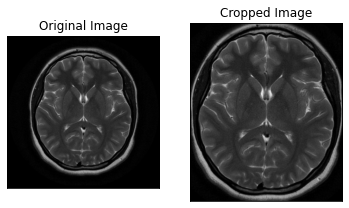

In [ ]:
ex_img = cv2.imread('/content/brain_tumor_dataset/no/1 no.jpeg')
img = crop_brain_contour(ex_img, plot=True)

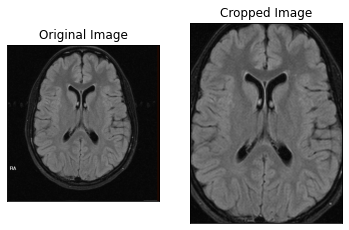

In [ ]:
ex_img = cv2.imread('/content/brain_tumor_dataset/no/No18.jpg')
img = crop_brain_contour(ex_img, plot=True)

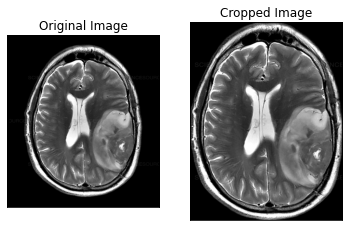

In [ ]:
ex_img = cv2.imread('/content/brain_tumor_dataset/yes/Y108.jpg')
img = crop_brain_contour(ex_img, plot=True)

In [ ]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [ ]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_train, y_train = load_data(['/content/train/yes', '/content/train/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 1867
X shape is: (1867, 240, 240, 3)
y shape is: (1867, 1)


In [ ]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

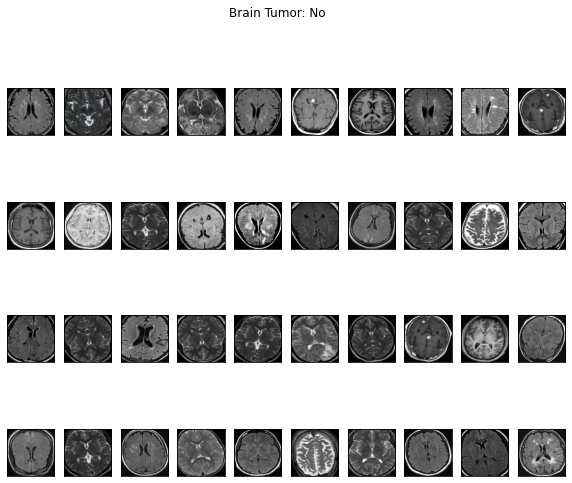

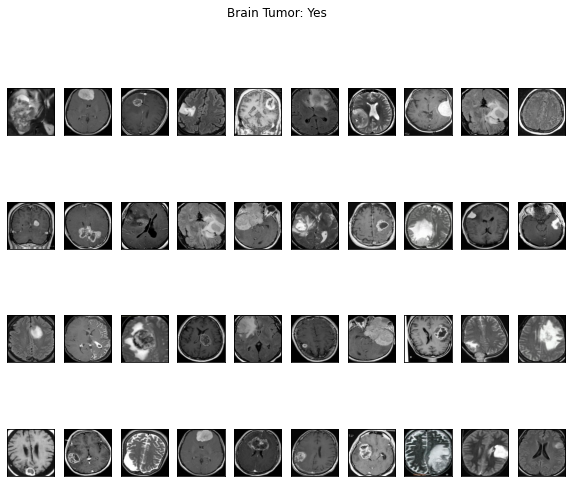

In [ ]:
plot_sample_images(X_train, y_train)

In [ ]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_test, y_test = load_data(['/content/test/yes', '/content/test/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 400
X shape is: (400, 240, 240, 3)
y shape is: (400, 1)


In [ ]:
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X_val, y_val = load_data(['/content/val/yes', '/content/val/no'], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 400
X shape is: (400, 240, 240, 3)
y shape is: (400, 1)


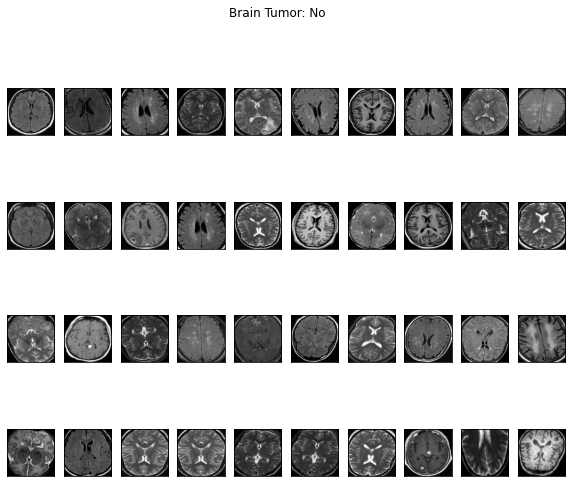

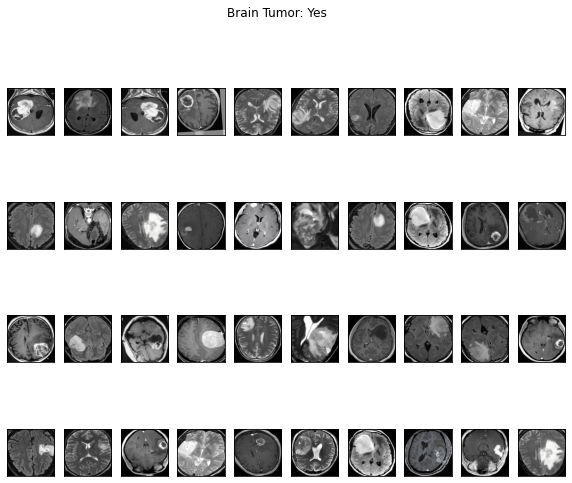

In [ ]:
plot_sample_images(X_val, y_val)

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (240, 240, 3)))

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.25)) 
model.add(Dense(units = 1, activation = 'sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 236, 236, 32)      4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 118, 118, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 116, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       7

In [ ]:
model.compile(optimizer = 'adam', loss = keras.losses.binary_crossentropy, metrics = ['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mc = ModelCheckpoint(monitor ='val_accuracy', filepath = './bestmodel.h5', verbose = 1, save_best_only = True, mode = 'auto')

cd = [es, mc]

In [ ]:
hist = model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cd, verbose = 1)

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 0.7197 - accuracy: 0.5726
Epoch 1: val_accuracy improved from -inf to 0.74250, saving model to ./bestmodel.h5
59/59 [==============================] - 22s 153ms/step - loss: 0.7197 - accuracy: 0.5726 - val_loss: 0.5776 - val_accuracy: 0.7425
Epoch 2/30
59/59 [==============================] - ETA: 0s - loss: 0.5152 - accuracy: 0.7542
Epoch 2: val_accuracy improved from 0.74250 to 0.79750, saving model to ./bestmodel.h5
59/59 [==============================] - 7s 127ms/step - loss: 0.5152 - accuracy: 0.7542 - val_loss: 0.4451 - val_accuracy: 0.7975
Epoch 3/30
58/59 [============================>.] - ETA: 0s - loss: 0.4608 - accuracy: 0.7872
Epoch 3: val_accuracy improved from 0.79750 to 0.81500, saving model to ./bestmodel.h5
59/59 [==============================] - 7s 124ms/step - loss: 0.4609 - accuracy: 0.7868 - val_loss: 0.4390 - val_accuracy: 0.8150
Epoch 4/30
58/59 [============================>.] - ETA: 0s - loss

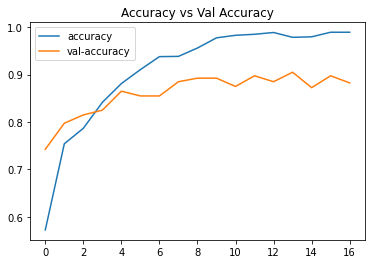

In [ ]:
h = hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

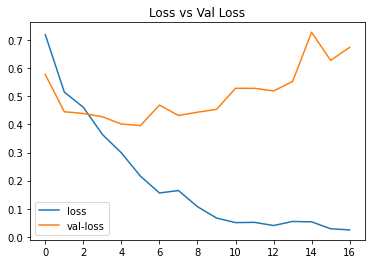

In [ ]:
h = hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('/content/bestmodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 1s 30ms/step - loss: 0.3284 - accuracy: 0.9150
The accuracy of our model is 0.9150000214576721


In [ ]:
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(input_shape=(240,240,3), include_top=False)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
  layer.trainable = False
     

In [ ]:
X = Flatten()(base_model.output)
X = Dense(units=1, activation='sigmoid')(X)
transfer_model = Model(base_model.input, X)

In [ ]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 120, 120, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 120, 120, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 120, 120, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 120, 120, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 120, 120, 32)     128       
 ation)                                                      

In [ ]:
transfer_model.compile(optimizer='rmsprop', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
est = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 5, verbose = 1, mode = 'auto')
mct = ModelCheckpoint(monitor ='val_accuracy', filepath = './besttransfermodel.h5', verbose = 1, save_best_only = True, mode = 'auto')
cdt = [est, mct]

In [ ]:
transfer_hist = transfer_model.fit(x = X_train, y = y_train, batch_size = 32, epochs = 30, validation_data = (X_val, y_val), callbacks = cdt, verbose = 1)

Epoch 1/30
59/59 [==============================] - ETA: 0s - loss: 2.0061 - accuracy: 0.8302
Epoch 1: val_accuracy improved from -inf to 0.95750, saving model to ./besttransfermodel.h5
59/59 [==============================] - 8s 82ms/step - loss: 2.0061 - accuracy: 0.8302 - val_loss: 0.3777 - val_accuracy: 0.9575
Epoch 2/30
58/59 [============================>.] - ETA: 0s - loss: 0.3310 - accuracy: 0.9569
Epoch 2: val_accuracy did not improve from 0.95750
59/59 [==============================] - 3s 55ms/step - loss: 0.3290 - accuracy: 0.9572 - val_loss: 0.3472 - val_accuracy: 0.9375
Epoch 3/30
59/59 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.9539
Epoch 3: val_accuracy improved from 0.95750 to 0.98500, saving model to ./besttransfermodel.h5
59/59 [==============================] - 3s 58ms/step - loss: 0.3607 - accuracy: 0.9539 - val_loss: 0.1368 - val_accuracy: 0.9850
Epoch 4/30
58/59 [============================>.] - ETA: 0s - loss: 0.0914 - accuracy: 0.9

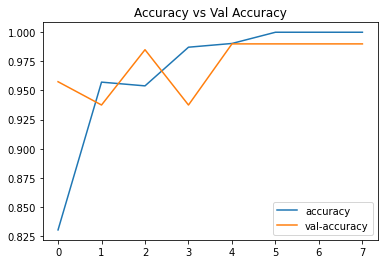

In [ ]:
h = transfer_hist.history
plt.plot(h['accuracy'], label = 'accuracy')
plt.plot(h['val_accuracy'], label = 'val-accuracy')
plt.title('Accuracy vs Val Accuracy')
plt.legend()
plt.show()

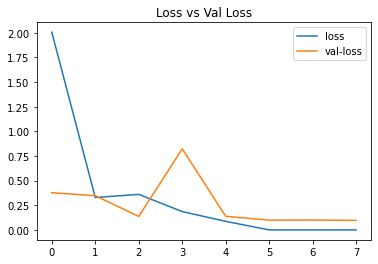

In [ ]:
h = transfer_hist.history
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val-loss')
plt.title('Loss vs Val Loss')
plt.legend()
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('/content/besttransfermodel.h5')
acc = model.evaluate(X_test, y_test)[1]
print(f'The accuracy of our model is {acc}')

13/13 [==============================] - 1s 44ms/step - loss: 0.1394 - accuracy: 0.9900
The accuracy of our model is 0.9900000095367432
